In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [130]:
BATCH_SIZE = 64

In [5]:
cd /content/drive/MyDrive/DL/HW2

/content/drive/MyDrive/DL/HW2


In [120]:
train_dataframe = pd.read_csv('./data/Q3_train.csv')
test_dataframe = pd.read_csv('./data/Q3_test.csv')
# train_dataframe = train_dataframe.sample(frac = 1)
split = int(len(train_dataframe)*0.2)
eval_dataframe = train_dataframe.iloc[0:split,:]
train_dataframe = train_dataframe.iloc[split:,:]

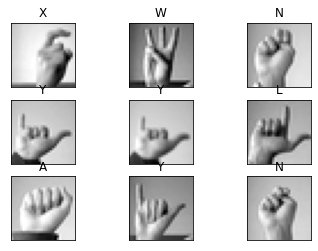

In [122]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  selected_data = train_dataframe.sample()
  label = selected_data['label'].values[0]
  letter = chr(ord('@')+(label+1))
  pixels = selected_data[selected_data.columns[1:]].values.tolist()
  image = np.array(pixels, dtype=np.uint8).reshape((28,28))
  plt.imshow(image, cmap='gray')
  plt.title(letter)
  plt.xticks([])
  plt.yticks([])
fig.show()

In [75]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
class AlphabetDataset(Dataset):
 
  def __init__(self,df): 
    x=df.iloc[:,1:].values
    y=df.iloc[:,0].values
    self.x=torch.tensor(x,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=int)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,i):
    return self.x[i],self.y[i]

In [131]:

train_dataset = AlphabetDataset(train_dataframe)
test_dataset = AlphabetDataset(test_dataframe)
eval_dataset = AlphabetDataset(eval_dataframe)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)

##**Simple Model**

In [111]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


class AlphabetNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(784, 1024)
      self.fc2 = nn.Linear(1024, 512)
      self.fc3 = nn.Linear(512, 256)
      self.fc4 = nn.Linear(256, 128)
      self.fc5 = nn.Linear(128, 64)
      self.fc6 = nn.Linear(64, 32)
      self.fc7 = nn.Linear(32, 26)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      x = F.relu(x)
      x = self.fc4(x)
      x = F.relu(x)
      x = self.fc5(x)
      x = F.relu(x)
      x = self.fc6(x)
      x = F.relu(x)
      logits = self.fc7(x)
      return logits

In [115]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


class DAlphabetNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.d = nn.Dropout(0.2)
      self.fc1 = nn.Linear(784, 1024)
      self.fc2 = nn.Linear(1024, 512)
      self.fc3 = nn.Linear(512, 256)
      self.fc4 = nn.Linear(256, 128)
      self.fc5 = nn.Linear(128, 64)
      self.fc6 = nn.Linear(64, 32)
      self.fc7 = nn.Linear(32, 26)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.d(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.d(x)
      x = self.fc3(x)
      x = F.relu(x)
      x = self.d(x)
      x = self.fc4(x)
      x = F.relu(x)
      x = self.d(x)
      x = self.fc5(x)
      x = F.relu(x)
      x = self.d(x)
      x = self.fc6(x)
      x = F.relu(x)
      x = self.d(x)
      logits = self.fc7(x)
      return logits

In [79]:
def calculate_accuracy(logits, labels):
  predictions = torch.argmax(logits, dim=1)
  true = torch.sum(predictions==labels)
  return true

def evaluate(dataloader, model):
  loss_function = nn.CrossEntropyLoss()
  eval_loss = 0
  total_true = 0
  for x,y in dataloader:
    with torch.no_grad():
      logits = model(x)
      loss = loss_function(logits, y)
      eval_loss+= loss.item()
      total_true+= calculate_accuracy(logits, y)
  acuuracy = total_true/len(dataloader.dataset)
  print('loss ', eval_loss)
  print('accuracy ', acuuracy)
  return eval_loss

In [95]:
def train_loop(model, optimizer, epoch_nm):
  loss_function = nn.CrossEntropyLoss(reduction='mean')
  train_loss_list =[]
  eval_loss_list = []
  for epoch in range(0,epoch_nm):
    train_loss =0
    print('-'*10, epoch, '-'*10,'\n')
    for x,y in tqdm(train_loader):
      logits = model(x)
      loss = loss_function(logits, y)
      train_loss+= loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss_list.append(train_loss)
    print('train loss ', train_loss)
    eval_loss_list.append(evaluate(eval_loader, model))
  # print(eval_loss_list)
  return train_loss_list, eval_loss_list


In [81]:
def draw_loss(l1,l2):
  y = range(0,len(l1))
  plt.plot(y, l1,  label = "train loss")
  plt.plot(y, l2, label = "test loss")
  plt.legend()
  plt.show()



SGD method is the GD algorythem applied on every single batch insted of the whole data

---------- simple model with SGD optimizer ----------
---------- 0 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 100.93it/s]


train loss  3615.7300913333893
loss  679.4942002296448
accuracy  tensor(0.3573)
---------- 1 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 103.90it/s]


train loss  2343.5593779683113
loss  644.0843183994293
accuracy  tensor(0.4048)
---------- 2 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 104.23it/s]


train loss  1621.547751903534
loss  460.9217990040779
accuracy  tensor(0.5649)
---------- 3 ---------- 



100%|██████████| 1373/1373 [00:14<00:00, 96.51it/s] 


train loss  1282.2157852500677
loss  489.3764509111643
accuracy  tensor(0.5671)
---------- 4 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 103.91it/s]


train loss  859.9475850500166
loss  84.60235230997205
accuracy  tensor(0.9224)
---------- 5 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 102.83it/s]


train loss  632.8603772744536
loss  79.99356546066701
accuracy  tensor(0.9217)
---------- 6 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 102.52it/s]


train loss  421.82337744464166
loss  93.50648484099656
accuracy  tensor(0.9069)
---------- 7 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 105.70it/s]


train loss  373.3706774287857
loss  27.06736838980578
accuracy  tensor(0.9820)
---------- 8 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 104.46it/s]


train loss  467.102730866638
loss  88.50942656584084
accuracy  tensor(0.9408)
---------- 9 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.40it/s]


train loss  370.82151881745085
loss  14.551619458245113
accuracy  tensor(0.9865)
---------- 10 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 105.56it/s]


train loss  206.83290879292326
loss  4.395191971299937
accuracy  tensor(0.9978)
---------- 11 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.33it/s]


train loss  20.14453593203143
loss  0.269781036528002
accuracy  tensor(1.)
---------- 12 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.00it/s]


train loss  0.5489835572852826
loss  0.1445280963021105
accuracy  tensor(1.)
---------- 13 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.10it/s]


train loss  0.3091481201846591
loss  0.09739537334053239
accuracy  tensor(1.)
---------- 14 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.94it/s]


train loss  0.21714116261466643
loss  0.07814850596116685
accuracy  tensor(1.)
---------- 15 ---------- 



100%|██████████| 1373/1373 [00:14<00:00, 97.39it/s] 


train loss  0.1662350192705162
loss  0.06420739255554508
accuracy  tensor(1.)
---------- 16 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.73it/s]


train loss  0.13441949710454537
loss  0.05784969590763467
accuracy  tensor(1.)
---------- 17 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.44it/s]


train loss  0.11260851819520212
loss  0.04911720649846529
accuracy  tensor(1.)
---------- 18 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 107.28it/s]


train loss  0.09655060366321777
loss  0.04221236743137524
accuracy  tensor(1.)
---------- 19 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 107.19it/s]


train loss  0.08488430151305693
loss  0.04047547655409289
accuracy  tensor(1.)
---------- 20 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 108.20it/s]


train loss  0.07536001879122978
loss  0.03596781036321772
accuracy  tensor(1.)
---------- 21 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.05it/s]


train loss  0.06788847836247669
loss  0.03413823096076385
accuracy  tensor(1.)
---------- 22 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 106.30it/s]


train loss  0.061580391013507096
loss  0.03223505140107363
accuracy  tensor(1.)
---------- 23 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 105.36it/s]


train loss  0.05638555153691982
loss  0.02937268729272091
accuracy  tensor(1.)
---------- 24 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 104.61it/s]


train loss  0.05186173903867086
loss  0.029087000820368303
accuracy  tensor(1.)
---------- 25 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 107.43it/s]


train loss  0.0482294150888265
loss  0.02684948693070055
accuracy  tensor(1.)
---------- 26 ---------- 



100%|██████████| 1373/1373 [00:12<00:00, 105.73it/s]


train loss  0.04482380222773941
loss  0.025695172284997625
accuracy  tensor(1.)
---------- 27 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 105.19it/s]


train loss  0.041923183946892095
loss  0.025185516065221236
accuracy  tensor(1.)
---------- 28 ---------- 



100%|██████████| 1373/1373 [00:14<00:00, 96.76it/s] 


train loss  0.039365785469840375
loss  0.02305613406603868
accuracy  tensor(1.)
---------- 29 ---------- 



100%|██████████| 1373/1373 [00:13<00:00, 104.56it/s]


train loss  0.037100767312779226
loss  0.02240976334457656
accuracy  tensor(1.)
loss  524.5183784517722
accuracy  tensor(0.8339)


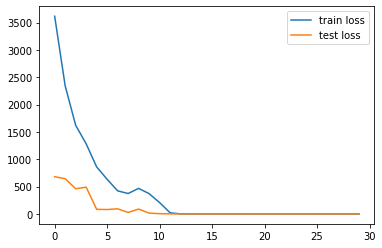

In [126]:
#Batch size = 16
print('-'*10, 'simple model with SGD optimizer', '-'*10)
sgd_alphabet_net = AlphabetNet()
sgd_optimizer = optim.SGD(sgd_alphabet_net.parameters(), lr=0.01)
train_loss_list, eval_loss_list = train_loop(sgd_alphabet_net, sgd_optimizer, 30)
evaluate(test_loader, sgd_alphabet_net)
draw_loss(train_loss_list, eval_loss_list)





Adam method changs the learning rate based on the first-order and second-order moments.

---------- simple model with Adam optimizer ----------
---------- 0 ---------- 



100%|██████████| 344/344 [00:11<00:00, 29.55it/s]


train loss  1059.1692514419556
loss  240.13132095336914
accuracy  tensor(0.1348)
---------- 1 ---------- 



100%|██████████| 344/344 [00:10<00:00, 31.89it/s]


train loss  813.0684510469437
loss  181.7459956407547
accuracy  tensor(0.2989)
---------- 2 ---------- 



100%|██████████| 344/344 [00:18<00:00, 18.66it/s]


train loss  609.9002788066864
loss  134.59630620479584
accuracy  tensor(0.4445)
---------- 3 ---------- 



100%|██████████| 344/344 [00:18<00:00, 19.05it/s]


train loss  468.72444289922714
loss  146.05188989639282
accuracy  tensor(0.4540)
---------- 4 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.24it/s]


train loss  371.90194338560104
loss  82.8641282916069
accuracy  tensor(0.6685)
---------- 5 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.39it/s]


train loss  292.8373802304268
loss  65.89996993541718
accuracy  tensor(0.7119)
---------- 6 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.12it/s]


train loss  213.5074438750744
loss  42.58100122213364
accuracy  tensor(0.8137)
---------- 7 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.21it/s]


train loss  143.96626076847315
loss  30.231210082769394
accuracy  tensor(0.8711)
---------- 8 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.17it/s]


train loss  102.57492714375257
loss  17.202776476740837
accuracy  tensor(0.9359)
---------- 9 ---------- 



100%|██████████| 344/344 [00:18<00:00, 18.35it/s]


train loss  74.54021340981126
loss  12.062903508543968
accuracy  tensor(0.9536)
---------- 10 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.41it/s]


train loss  63.192421643063426
loss  17.873676896095276
accuracy  tensor(0.9266)
---------- 11 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.47it/s]


train loss  58.62611803365871
loss  7.661586762405932
accuracy  tensor(0.9663)
---------- 12 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.36it/s]


train loss  73.15585461445153
loss  6.040156030096114
accuracy  tensor(0.9754)
---------- 13 ---------- 



100%|██████████| 344/344 [00:17<00:00, 19.26it/s]


train loss  38.88321787118912
loss  21.404259338974953
accuracy  tensor(0.9133)
---------- 14 ---------- 



100%|██████████| 344/344 [00:18<00:00, 19.00it/s]


train loss  43.07636830932461
loss  12.192743949592113
accuracy  tensor(0.9536)
loss  158.02854692935944
accuracy  tensor(0.6983)


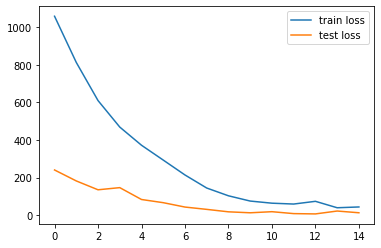

In [133]:
#Batch_size = 64
print('-'*10, 'simple model with Adam optimizer', '-'*10)
adam_alphabet_net = AlphabetNet()
adam_optimizer = optim.Adam(adam_alphabet_net.parameters(), lr=0.001)
train_loss_list, eval_loss_list = train_loop(adam_alphabet_net, adam_optimizer,15)
evaluate(test_loader, adam_alphabet_net)
draw_loss(train_loss_list, eval_loss_list)


Drop out freeze some nodes of a layer at a specific epoch. These prevent overfitting of the model and it's kind of regularization.

---------- model with dropout and SGD optimizer ----------
---------- 0 ---------- 



100%|██████████| 344/344 [00:06<00:00, 53.83it/s]


train loss  1089.1805276870728
loss  260.895046710968
accuracy  tensor(0.0920)
---------- 1 ---------- 



100%|██████████| 344/344 [00:06<00:00, 55.29it/s]


train loss  987.4466545581818
loss  222.47629356384277
accuracy  tensor(0.1787)
---------- 2 ---------- 



100%|██████████| 344/344 [00:07<00:00, 48.97it/s]


train loss  869.5892494916916
loss  203.1109540462494
accuracy  tensor(0.2125)
---------- 3 ---------- 



100%|██████████| 344/344 [00:06<00:00, 53.90it/s]


train loss  778.1467155218124
loss  212.35711359977722
accuracy  tensor(0.2247)
---------- 4 ---------- 



100%|██████████| 344/344 [00:06<00:00, 56.16it/s]


train loss  719.6024129390717
loss  171.52619862556458
accuracy  tensor(0.3176)
---------- 5 ---------- 



100%|██████████| 344/344 [00:06<00:00, 55.23it/s]


train loss  660.0691229104996
loss  185.7873054742813
accuracy  tensor(0.2932)
---------- 6 ---------- 



100%|██████████| 344/344 [00:06<00:00, 54.70it/s]


train loss  606.6520991325378
loss  143.29467701911926
accuracy  tensor(0.4109)
---------- 7 ---------- 



100%|██████████| 344/344 [00:06<00:00, 56.15it/s]


train loss  624.641036272049
loss  212.37942790985107
accuracy  tensor(0.2803)
---------- 8 ---------- 



100%|██████████| 344/344 [00:06<00:00, 55.99it/s]


train loss  552.2318633794785
loss  121.30093204975128
accuracy  tensor(0.4992)
---------- 9 ---------- 



100%|██████████| 344/344 [00:06<00:00, 55.93it/s]


train loss  499.609299659729
loss  212.98449742794037
accuracy  tensor(0.3482)
---------- 10 ---------- 



100%|██████████| 344/344 [00:06<00:00, 53.66it/s]


train loss  484.35741460323334
loss  138.13210117816925
accuracy  tensor(0.4837)
---------- 11 ---------- 



100%|██████████| 344/344 [00:06<00:00, 51.57it/s]


train loss  457.58543062210083
loss  135.094735622406
accuracy  tensor(0.4691)
---------- 12 ---------- 



100%|██████████| 344/344 [00:07<00:00, 43.92it/s]


train loss  417.05619871616364
loss  103.56266558170319
accuracy  tensor(0.5744)
---------- 13 ---------- 



100%|██████████| 344/344 [00:06<00:00, 53.11it/s]


train loss  370.5621756911278
loss  91.26069223880768
accuracy  tensor(0.6247)
---------- 14 ---------- 



100%|██████████| 344/344 [00:06<00:00, 52.91it/s]


train loss  354.5341864824295
loss  101.02100789546967
accuracy  tensor(0.5970)
loss  193.7720193862915
accuracy  tensor(0.4859)


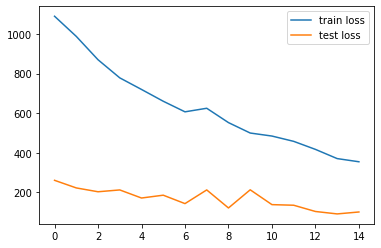

In [135]:
#Batch_size = 64
print('-'*10, 'model with dropout and SGD optimizer', '-'*10)
d_alphabet_net = DAlphabetNet()
adam_optimizer = optim.SGD(d_alphabet_net.parameters(), lr=0.01)
train_loss_list, eval_loss_list = train_loop(d_alphabet_net, adam_optimizer, 15)
evaluate(test_loader, d_alphabet_net)
draw_loss(train_loss_list, eval_loss_list)


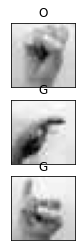

In [142]:
fig = plt.figure()
for i in range(3):
  plt.subplot(3,1,i+1)
  image = plt.imread(f'./data/image_sample/sample{i+1}.jpg')
  input_data = torch.tensor(image.ravel(), dtype=torch.float32)
  logits = sgd_alphabet_net(input_data)
  prediction = torch.argmax(logits)
  letter = chr(ord('@')+(prediction))
  plt.imshow(image, cmap='gray')
  plt.title(letter)
  plt.xticks([])
  plt.yticks([])
fig.show()